In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

# Observation Definitions

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def spec_modify(sp_sci, kmag_sci, args_disk):
    """
    2MASS K-Band mags include disk flux.
    Modify stellar spectrum to exclude disk flux
    """

    # Determine real stellar spectrum. 2MASS K-Band mags include disk flux!
    filt = 'F210M'
    bp = pynrc.read_filter(filt)
    obs_sci = S.Observation(sp_sci, bp, binset=bp.wave)
    tot_flux = obs_sci.effstim('counts')
    hdu_disk = model_to_hdulist(args_disk, sp_sci, filt)
    disk_flux = hdu_disk[0].data.sum()
    star_flux = tot_flux - disk_flux

    # Value to scale stellar flux
    scale = star_flux / tot_flux
    kmag_sci_new = kmag_sci - 2.5*np.log10(star_flux / tot_flux)
    sp_sci2 = sp_sci.renorm(kmag_sci_new, 'vegamag', bp_k)
    sp_sci2.name = sp_sci.name
    return sp_sci2

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, args_disk=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 160 pixels. 
    However, for the case of F200W+MASK335R, we will assume that the 
    subarray size matches that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if args_disk is not None:
            # Convert to photons/sec in specified filter
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)

        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        fov_pix = subsize = 160 if mask is None else 320
        oversample = 2

        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, 
                                               disk_hdu=hdu_disk, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                               verbose=verbose)
    return obs_dict

In [18]:
def obs_optimize(obs_dict, sp_opt=None, well_levels=None, **kwargs):
    """
    Perform ramp optimization on each science and reference observation
    in a list of filter observations. Updates the detector MULTIACCUM
    settings for each observation in the dictionary.
    
    snr_goal = 5
    snr_frac = 0.02
    tacq_max = 1400
    tacq_frac = 0.01
    nint_min = 15
    ng_max = 10
    """

    # A very faint bg object on which to maximize S/N
    # If sp_opt is not set, then default to a 20th magnitude flat source
    if sp_opt is None:
        bp_k = S.ObsBandpass('k')
        sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)

    
    # Some observations may saturate, so define a list of  maximum well level
    # values that we will incrementally check until a ramp setting is found
    # that meets the contraints.
    if well_levels is None:
        well_levels = [0.8, 1.5, 3.0, 5.0, 10.0, 20.0, 100.0, 150.0, 300.0, 500.0]
   
    filt_keys = obs_dict.keys()
    filt_keys.sort()
    print(['Pattern', 'NGRP', 'NINT', 't_int', 't_exp', 't_acq', 'SNR', 'Well', 'eff'])
    for j, key in enumerate(filt_keys):
        print('')
        print(key)

        obs = obs_dict[key]
        sp_sci, sp_ref = (obs.sp_sci, obs.sp_ref)

        sci = obs
        ref = sci.nrc_ref

        # Always use RAPID, NGRP=10, NINT=1100 for
        if obs.mask is None:
            kwargs['patterns'] = ['RAPID']
            kwargs['even_nints'] = False
            kwargs['ng_min'] = 10
            kwargs['tacq_frac'] = 0.01
            well_levels = [500]
        else:
            kwargs['patterns'] = ['BRIGHT2', 'SHALLOW4']
            kwargs['even_nints'] = True
            kwargs['ng_min'] = 2
            kwargs['tacq_frac'] = 0.1
            well_levels = [0.8]
            
        # Ramp optimization for both science and reference targets
        for obs2, sp in zip([sci, ref], [sp_sci, sp_ref]):
            i = nrow = 0
            while nrow==0:
                well_max = well_levels[i]
                tbl = obs2.ramp_optimize(sp_opt, sp, well_frac_max=well_max, **kwargs)
                nrow = len(tbl)
                i+=1
                
            # Grab the highest ranked MULTIACCUM settings and update the detector readout
            v1, v2, v3 = tbl['Pattern', 'NGRP', 'NINT'][0]
            
            vals = tbl[0].as_void()
            strout = ', '.join(map(str, vals))
            print(strout)
            
            if obs.mask is not None: v3 = int(v3/2)
            obs2.update_detectors(read_mode=v1, ngroup=v2, nint=v3)
        

## Plotting contrasts and planet magnitudes

In [7]:
def plot_contrasts(curves, wfe_list, ax=None, colors=None):
    """Plot a series of contrast curves for corresponding WFE drifts."""
    if ax is None:
        fig, ax = subplots()
    if colors is None:
        colors = plt.cm.Blues(np.linspace(0,1,len(wfe_list)+3))[::-1]
    for j, wfe_drift in enumerate(wfe_list):
        rr, contrast, mag_sens = curves[j]
        label="WFE Drift = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label, color=colors[j], zorder=1, lw=2)


def planet_mags(obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Determine series of exoplanet magnitudes for given observation."""

    pmag = {}
    for i,m in enumerate(mass_list):
        flux_list = []
        for j,av in enumerate(av_vals):
            sp = obs.planet_spec(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s')
            sp_obs = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
            flux = sp_obs.effstim('vegamag')
            flux_list.append(flux)
        pmag[m] = tuple(flux_list)
        
    return pmag

        
def plot_planet_patches(ax, obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Plot exoplanet magnitudes in region corresponding to extinction values."""
    import matplotlib.patches as patches
    
    xlim = ax.get_xlim()
    cols = plt.cm.tab10(np.linspace(0,1,10))
    
    pmag = planet_mags(obs, age, entropy, mass_list, av_vals)
    for i,m in enumerate(mass_list):
        pm_min, pm_max = pmag[m]
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pm_min), xlim[1], pm_max-pm_min, alpha=0.2,
                                 color=cols[i], label=label, zorder=2)
        ax.add_patch(rect)
        ax.plot(xlim, [pm_min]*2, color=cols[i], lw=1, alpha=0.3)
        ax.plot(xlim, [pm_max]*2, color=cols[i], lw=1, alpha=0.3)
        

    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, lambda: "Warm")
    ent_str = entropy_string + ' Start'
    #ent_str = '{} Start'.format(entropy_string)

    av_str = '$A_V = [{},{}]$'.format(av_vals[0],av_vals[1])
    age_str = 'Age = {} Myr'.format(age)

    ax.set_title('{} -- {} ({}; {})'.format(obs.filter,ent_str,age_str,av_str))


## Define Source and their Reference Counterparts

In [8]:
#                source,      dist, sptype, kmag, fov_asec
args_sources = [('SAO 206462', 140, 'F8V',   5.8),
                ('MWC 758',    280, 'A8V',   5.8),
                ('HL Tau',     140, 'K5V',   7.4),
                ('TW Hya',      54, 'M0V',   7.3)]

# Corresponding reference stars
ref_sources =  [('HD 135343',   78, 'F3V',   7.0),
                ('HD 135343',   78, 'F3V',   7.0),
                ('HD 29714',    54, 'G2V',   7.8),
                ('HD 29714',    54, 'G2V',   7.8)]

In [9]:
# K-Band Filter
# 2MASS Bandpass
#from astropy.io import ascii
#tbl = ascii.read("2mass_ks.txt", names=['Wave', 'Throughput'])
#bp_k = S.ArrayBandpass(tbl['Wave']*1E4, tbl['Throughput'], name='Ks')
bp_k = S.ObsBandpass('k')

In [10]:
# List of filters
args_list =  [('F187N', None, None),
              ('F200W', None, None),
              ('F356W', None, None),
              ('F444W', None, None)]

args_list =  [('F356W', None, None),
              ('F444W', None, None),
              ('F356W', 'MASK335R', 'CIRCLYOT'),
              ('F444W', 'MASK335R', 'CIRCLYOT')]


filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## Functions to init, optimize, and plot contrast

In [11]:
# Generate initial observations for each filter(no WFE drift)
def do_init():
    wfe_drift = 0
    obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk)
    return obs_dict

In [12]:
# Optimize observations
def do_opt(tacq_max):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max)

In [13]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, nsig=5):
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves   = []
        for wfe_drift in wfe_list:
            obs.wfe_drift = wfe_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [14]:
save_fig = True
def do_plot():
    nwfe = len(wfe_list)
    lin_vals = np.linspace(0.2,0.7,nwfe)
    blues = plt.cm.Blues_r(lin_vals)[::-1]
    reds  = plt.cm.Reds_r(lin_vals)[::-1]
    colors = [blues, reds]

    fig, axes = plt.subplots(2,2, figsize=(14,8))
    entropy_vals = [13,8]

    xlim = [0,10]
    ylim = [24,10]

    filts = ['F356W', 'F444W']
    for i, axes2 in enumerate(axes):
        for j, ax in enumerate(axes2):
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            k=0
            for key in filt_keys:
                if filts[i] in key:
                    plot_contrasts(contrast_all[key], wfe_list, ax=ax, colors=colors[k])
                    if k==0:
                        plot_planet_patches(ax, obs_dict[key], entropy=entropy_vals[j])
                    k += 1

    import matplotlib.patches as mpatches
    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim([0,10])
        ax.set_ylim(ylim)

        handles, labels = ax.get_legend_handles_labels()
        h1 = handles[0:nwfe]
        h2 = handles[nwfe:2*nwfe]
        h3 = handles[2*nwfe:]
        h1_t = [mpatches.Patch(color='none', label='Direct Imaging')]
        h2_t = [mpatches.Patch(color='none', label='Coronagraphy')]
        handles = h1_t + h1 + h2_t + h2 + h3

        ax.legend(ncol=3, handles=handles)


    fig.tight_layout()

    tacq = obs_dict[filt_keys[0]].multiaccum_times['t_acq']
    tacq = round(tacq/100)*100
    fig.suptitle('{} (t_acq = {:.0f} sec)'.format(name_sci, tacq), fontsize=16);
    fig.subplots_adjust(top=0.9)

    outdir  = '/Volumes/NIRData/'
    fname = "{}_{:.0f}s.pdf".format(name_sci.replace(" ", ""), tacq)
    if save_fig: 
        if multi_fig:
            pdf.savefig(fig)
        else:
            fig.savefig(outdir+fname)

### SAO 206462

In [19]:
i=0

# Disk model information
# File name, arcsec/pix, dist (pc), wavelength (um), flux units
args_disk = ('example_disk.fits', 0.007, 140.0, 1.6, 'mJy/arcsec^2')

name_sci, dist_sci, spt_sci, kmag_sci = args_sources[i]
name_ref, dist_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k)
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
sp_sci.name = name_sci
sp_ref.name = name_ref

# Modify the stellar spectrum so that disk+star = kmag
if args_disk is not None:
    sp_sci = spec_modify(sp_sci, kmag_sci, args_disk)

In [ ]:
# List of WFE drifts to check
wfe_list = [0,2,5,10][::-1]
nsig = 5

# Target acquisition times to check
tacq_list = [500,1000,2000,3000]

save_fig = True
multi_fig = True

outdir  = '/Volumes/NIRData/'
fname = outdir + name_sci.replace(" ", "") + '.pdf'
with PdfPages(fname) as pdf:
    for tacq in tacq_list:
        print(name_sci, tacq)
        # Initialize observations
        obs_dict = do_init()
        # Optimize readout parameters
        do_opt(tacq)
        # Get contrasts for each WFE drift
        contrast_all = do_contrast(wfe_list, nsig=nsig)
        # Plot contrast comparisons
        do_plot()

        clear_output(wait=True)


### Remaining Sources

In [ ]:
for i in [1,2,3]:
    
    # Disk model information
    args_disk = None

    name_sci, dist_sci, spt_sci, kmag_sci = args_sources[i]
    name_ref, dist_ref, spt_ref, kmag_ref = ref_sources[i]

    # Science target and reference star spectra
    sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k)
    sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k)
    sp_sci.name = name_sci
    sp_ref.name = name_ref

    # Modify the stellar spectrum so that disk+star = kmag
    if args_disk is not None:
        sp_sci = spec_modify(sp_sci, kmag_sci, args_disk)
        
    # List of WFE drifts to check
    wfe_list = [0,2,5,10][::-1]
    nsig = 5

    # Target acquisition times to check
    tacq_list = [500,1000,2000,3000]

    save_fig = True
    multi_fig = True

    outdir  = '/Volumes/NIRData/'
    fname = outdir + name_sci.replace(" ", "") + '.pdf'
    with PdfPages(fname) as pdf:
        for tacq in tacq_list:
            print(name_sci, tacq)
            # Initialize observations
            obs_dict = do_init()
            # Optimize readout parameters
            do_opt(tacq)
            # Get contrasts for each WFE drift
            contrast_all = do_contrast()
            # Plot contrast comparisons
            do_plot()

            clear_output(wait=True)


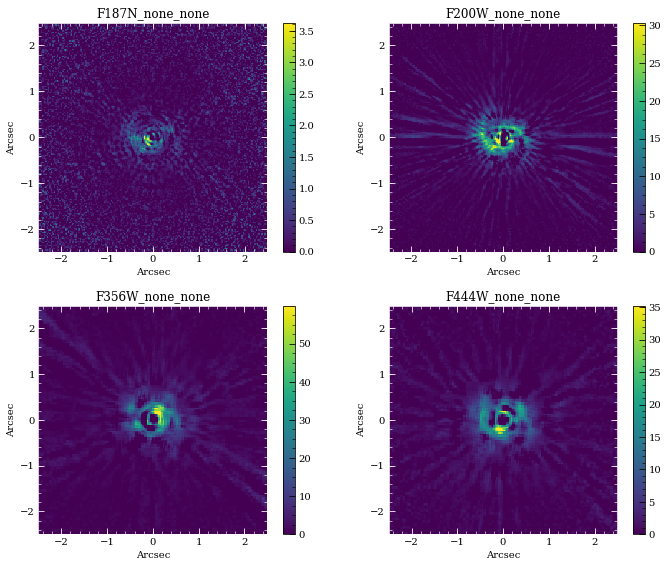

In [12]:
import webbpsf 

fig, axes = plt.subplots(2,2, figsize=(10,8))
axes = axes.flatten()

cmap = matplotlib.rcParams['image.cmap']
for i, ax in enumerate(axes):
    hdulist = final_hdus[i]
    data = hdulist[0].data
    
    vmax = data.max() * 0.75
    vmin = 0 #vmax/10000 #np.min([0,data.min()])
    ax, cb = webbpsf.display_psf(hdulist, ax=ax, title=filt_keys[i], colorbar=True, cmap=cmap,
                                 scale='linear', vmin=vmin, vmax=vmax, imagecrop=5, return_ax=True)
    cb.set_label('')

    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    
    ax.minorticks_on()

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')


fig.tight_layout()